In [4]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
# svm
from sklearn.svm import SVC
# image descriptors
from skimage.feature import hog, local_binary_pattern, daisy, ORB, BRIEF, CENSURE
from skimage import io, color, exposure
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage import data
import skimage.feature
from sklearn.ensemble import RandomForestClassifier
# mlp
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve, validation_curve, StratifiedKFold, KFold
import io
from PIL import Image, ImageOps
import cv2
from sklearn.preprocessing import MinMaxScaler
from skimage.util import view_as_blocks, img_as_ubyte
from multiprocessing import Pool
import skimage.feature as ed

# Loading stuff


In [6]:
# dataset_dir = "D:\\Computer Science\\TCC Ciência e Tecnologia\\src\\others\\DogFaceNet\\dogfacenet_dataset"

images_dir = "C:\\Users\\T-Gamer\\Desktop\\MyFuture\\oitavo semestre\\TCC\\TCC psao\\DogFaceNet_Dataset_224_1\\after_4_bis"

# images_dir = os.path.join(dataset_dir, "DogFaceNet_Dataset_224_1\\after_4_bis")

img_and_label_list = []

# every dir name is a label
for label in os.listdir(images_dir):
    label_dir = os.path.join(images_dir, label)
    for img in os.listdir(label_dir):
        img_and_label_list.append((os.path.join(label_dir, img), label))


df = pd.DataFrame(img_and_label_list, columns=["path", "label"])
pd.set_option('display.max_colwidth', None)
# display(df)
# df.to_csv("dogfacenet_dataset.csv", index=False)

# Spliting the dataset into train and test


In [7]:
#spliting dataset
# a, min_df = train_test_split(df, test_size=0.5, stratify=df["label"])



In [8]:
# Removing classes with less than 4 samples
df = df.groupby("label").filter(lambda x: len(x) > 3)

In [9]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"])

In [10]:
display(train_df)

,path,label
6115,C:\Users\T-Gamer\Desktop\MyFuture\oitavo semestre\TCC\TCC psao\DogFaceNet_Dataset_224_1\after_4_bis\572\572.4.jpg,572
8270,C:\Users\T-Gamer\Desktop\MyFuture\oitavo semestre\TCC\TCC psao\DogFaceNet_Dataset_224_1\after_4_bis\985\985.1.jpg,985
2238,C:\Users\T-Gamer\Desktop\MyFuture\oitavo semestre\TCC\TCC psao\DogFaceNet_Dataset_224_1\after_4_bis\1386\1386.1.jpg,1386
736,C:\Users\T-Gamer\Desktop\MyFuture\oitavo semestre\TCC\TCC psao\DogFaceNet_Dataset_224_1\after_4_bis\1132\1132.2.jpg,1132
481,C:\Users\T-Gamer\Desktop\MyFuture\oitavo semestre\TCC\TCC psao\DogFaceNet_Dataset_224_1\after_4_bis\1081\1081.3.jpg,1081
...,...,...
3119,C:\Users\T-Gamer\Desktop\MyFuture\oitavo semestre\TCC\TCC psao\DogFaceNet_Dataset_224_1\after_4_bis\203\203.18.jpg,203
2371,C:\Users\T-Gamer\Desktop\MyFuture\oitavo semestre\TCC\TCC psao\DogFaceNet_Dataset_224_1\after_4_bis\1413\1413.3.jpg,1413
7317,C:\Users\T-Gamer\Desktop\MyFuture\oitavo semestre\TCC\TCC psao\DogFaceNet_Dataset_224_1\after_4_bis\792\792.0.jpg,792
5361,C:\Users\T-Gamer\Desktop\MyFuture\oitavo semestre\TCC\TCC psao\DogFaceNet_Dataset_224_1\after_4_bis\462\462.6.jpg,462


In [11]:
label_counts = train_df['label'].value_counts()
print(label_counts)

label
458    33
192    31
143    24
122    22
398    21
       ..
681     3
347     3
675     3
853     3
855     3
Name: count, Length: 1205, dtype: int64


In [12]:
label_counts = test_df['label'].value_counts()
print(label_counts)

label
458     8
192     8
372     6
143     6
122     6
       ..
1128    1
238     1
1050    1
1132    1
1192    1
Name: count, Length: 1205, dtype: int64


# Image preprocessing functions


In [13]:
def resize_img(img):
    return cv2.resize(img, (128, 128))

def print_data_shape(data):
    return data

def rgb2gray_img(img):
    # 0-255 integer array
    return (rgb2gray(img)*255).astype(np.uint8)

def extract_patches(img):
    img = np.atleast_2d(img)
    return extract_patches_2d(img, (8, 8))

def safe_imread(path):
    img = Image.open(path)
    if img is None:
        raise ValueError(f"Image couldn't be read from the path: {path}")
    return np.array(img)

def flatten(data):
    return data.flatten()

def hist_blocks(img, b_shape):
    return np.array([np.histogram(block.flatten(), bins=10, range=(0, 1))[0] for block in view_as_blocks(img, block_shape=b_shape).reshape(-1, *b_shape)])


# Some image descriptors!

In [14]:
def hog_descriptor(img):

    return hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1)).flatten()

def lbp_descriptor(img):

    return hist_blocks(
        local_binary_pattern(np.atleast_2d(img), P=8, R=1, method='uniform'),
        (8, 8)
    ).flatten()

def daisy_descriptor(img):
    return daisy(img).flatten()

def orb_descriptor(img):
    orb = ORB(n_keypoints=200)
    orb.detect_and_extract(img)
    return orb.descriptors.flatten()

def brief_descriptor(img):
    brief = BRIEF()
    brief.extract(img, )
    return brief.descriptors.flatten()

def censure_descriptor(img):
    censure = CENSURE()
    censure.detect(img)
    return censure.descriptors.flatten()

def color_histogram(img):
    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    # print("hist shape", hist.shape)
    return hist.flatten()


def block_mean(img):
    # Define the block size
    block_shape = (8, 8, 3)

    # Use view_as_blocks to divide the image into blocks
    blocks = view_as_blocks(img, block_shape)

    # Calculate the mean of each block and replicate it to fill the block
    mean_blocks = np.repeat(np.repeat(np.mean(blocks, axis=(1, 2, 3)), 8, axis=1), 8, axis=2)

    # Reshape the result to match the original image shape
    output = mean_blocks.reshape(img.shape)

    return output

def zigzag_fun(data: np.ndarray):
    return np.concatenate([np.diagonal(data[::-1, :], offset=i)[::(2*(i % 2)-1)] for i in range(1-data.shape[0], data.shape[0])])

dct_fun = np.vectorize(cv2.dct, signature='(m,n)->(m,n)')
zigzag_fun = np.vectorize(zigzag_fun, signature='(m,n)->(mxn)')

def color_layout_descriptor(img: np.ndarray):
    """" 
    Computes the Color Layout Descriptor (CLD) of an image.

    Stages
    -------
    Stage 1: Divide the image into 8x8 blocks.\n
    Stage 2: Calculate the average color for each block.\n
    Stage 3: Convert to YCbCr color space.\n
    Stage 4: Apply the Discrete Cosine Transform (DCT), to obtain 
    3 [8x8] matrix of 64 coefficients (DCTY, DCTCb, DCTCr).\n
    Stage 5: Perform zigzag scanning to obtain (DY, DCb, DCr)

    Parameters
    ----------
    img: ndarray
        The image to compute the descriptor.

    Returns
    -------
    ndarray
        The CLD of the image.
    """ 

    # Stage 1
    blocks = view_as_blocks(img, block_shape=(8, 8, 3)).reshape(-1, 8, 8, 3)

    #Stage 2
    icon_avg_img = np.mean(blocks, axis=(1, 2)).reshape(img.shape[0]//8, img.shape[1]//8, 3).astype(np.float32)

    avg_img = np.resize(icon_avg_img, img.shape)

    # Stage 3
    ycbcr = cv2.cvtColor(avg_img, cv2.COLOR_RGB2YCrCb)

    # Stage 4
    dct = dct_fun(cv2.split(ycbcr))

    return dct.flatten()

    # return dct.flatten()

    # Stage 5 - But why would I sort the dct?

    # zig = zigzag_fun(dct)
    
    # return zig.flatten()



# More image descriptors!

In [17]:
def mbp(img: np.ndarray) -> np.ndarray:
    """
    Compute the Median Binary Pattern (MLBP) of an image.
    The MBP differs from the original LBP in that the treshold is the median
    of the neighborhood instead of the center pixel.
    Source: https://doi.org/10.1007/978-3-540-74260-9_35

    Parameters
    ----------Global
    img : np.ndarray
        Input image. Must be a 2D array.

    Returns
    -------
    np.ndarray
        MBP image.
    """
    # Get the shape of the image
    height, width = img.shape

    # Pad the image
    pad_img = np.pad(img.copy(), 1, mode="symmetric")

    # Get the neighbors of the center pixel, starting from the top-left corner,
    # including the center pixel in the end as proposed by the authors
    idx = [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 1), (2, 0), (1, 0), (1, 1)]
    neighbors = np.array([pad_img[i:i + height, j:j + width] for i, j in idx])

    # Get the treshold 
    treshold = ndi.median_filter(img, size=3)

    # Compute the binary pattern
    mbp = np.zeros_like(img)
    for k, n in enumerate(neighbors):
        mbp = mbp | np.where(n >= treshold, 1 << k, 0)
    
    return mbp

def ltp(img: np.ndarray, treshold: int=5) -> np.ndarray:
    """
    Compute the Local Ternary Pattern (LTP) of an image.
    The LTP is a generalization of the LBP that considers the sign of the
    difference between the center pixel and its neighbors.
    Source: https://doi.org/10.1109/TIP.2010.2042645
    
    Parameters
    ----------
    img : np.ndarray
        Input image. Must be a 2D array.
    treshold : int
        Treshold value used for the LTP. Default is 5 as proposed by the authors.
            
    Returns 
    -------
    np.ndarray
        LTP image.
    """
    # Get the shape of the image
    height, width = img.shape

    # Pad the image
    pad_img = np.pad(img.copy(), 1, mode="symmetric")

    # Get the neighbors of the center pixel, starting from the top-left corner
    idx = [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 1), (2, 0), (1, 0)]
    neighbors = np.array([pad_img[i:i + height, j:j + width] for i, j in idx])

    # Compute the ternary pattern
    pltp, nltp = np.zeros_like(img), np.zeros_like(img)
    for k, n in enumerate(neighbors):
        pltp = pltp | np.where(n > (img + treshold), 1 << k, 0)
        nltp = nltp | np.where(n < (img - treshold), 1 << k, 0)
    
    return np.concatenate((pltp, nltp), axis=1)

def mtp(img: np.ndarray, treshold: int=10) -> np.ndarray:
    """
    Compute the Median Ternary Pattern (MTP) of an image.
    The MLTP is an extension of the LTP that considers the median of the
    neighborhood instead of the center pixel.
    Source: https://doi.org/10.1109/EICT.2014.6777846
    
    
    Parameters
    ----------
    img : np.ndarray
        Input image. Must be a 2D array.
    treshold : int
        Treshold value used for the LTP. Default is 10 as used by the authors.
            
    Returns 
    -------
    np.ndarray
        MTP image.
    """
    # Get the shape of the image
    height, width = img.shape

    # Pad the image
    pad_img = np.pad(img.copy(), 1, mode="symmetric")

    # Get the neighbors of the center pixel, starting from the top-left corner
    idx = [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 1), (2, 0), (1, 0)]
    neighbors = np.array([pad_img[i:i + height, j:j + width] for i, j in idx])

    # Get the treshold 
    treshold = ndi.median_filter(img, size=3)

    # Compute the ternary pattern
    pmtp, nmtp = np.zeros_like(img), np.zeros_like(img)
    for k, n in enumerate(neighbors):
        pmtp = pmtp | np.where(n > (img + treshold), 1 << k, 0)
        nmtp = nmtp | np.where(n < (img - treshold), 1 << k, 0)
    
    return np.concatenate((pmtp, nmtp), axis=1)

def gltp(img: np.ndarray, treshold: int=10) -> np.ndarray:
    """
    Compute the Gradient Local Ternary Pattern (GLTP) of an image.
    The GLTP is an extension of the LTP that considers the gradient of the
    image instead of the intensity.
    Source: https://doi.org/10.1155/2013/831747
    
    Parameters
    ----------
    img : np.ndarray
        Input image. Must be a 2D array.
    treshold : int
        Treshold value used for the GLTP. Default is 10 as used by the authors.
            
    Returns 
    -------
    np.ndarray
        GLTP image.
    """
    # Get the shape of the image
    height, width = img.shape

    # Pad the image
    pad_img = np.pad(img.copy(), 1, mode="symmetric")

    # Get the neighbors of the center pixel, starting from the top-left corner
    idx = [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 1), (2, 0), (1, 0)]
    neighbors = np.array([pad_img[i:i + height, j:j + width] for i, j in idx])

    # Get the gradient magnitude of the image
    gradient = ed.sobel_operator(img)

    # Compute the ternary pattern
    pgltp, ngltp = np.zeros_like(img), np.zeros_like(img)
    for k, n in enumerate(neighbors):
        pgltp = pgltp | np.where(n > (gradient + treshold), 1 << k, 0)
        ngltp = ngltp | np.where(n < (gradient - treshold), 1 << k, 0)
    
    return np.concatenate((pgltp, ngltp), axis=1)

def phog(img:np.ndarray, k: int=10, l: int=3):
    """
    Compute the Pyramid Histogram of Oriented Gradients (PHOG) of an image.
    The PHOG works by applying the hog descriptor at multiple resolutions in
    a spatial pyramid representation.
    Source: https://doi.org/10.1145/1282280.1282340

    Parameters
    ----------
    img : np.ndarray
        Input image. Must be a 2D array.
    k : int
        Number of bins in the histogram. As shown by the authors, the
        performance of the descriptor is not very sensitive to this parameter
        in the range [20-80], so the default is 20 to reduce the computational
        cost.
    l : int
        Number of levels in the pyramid. Prefer using it in the range [0, 3]
        to prevent overfitting. The default is 3.

    Returns
    -------
    np.ndarray
        PHOG descriptor.
    """
    # Get the edge contours with Canny detector
    mean = np.mean(img)
    edges = ed.canny(img, 0.66 * mean, 1.33 * mean)

    # Computing the gradients of the edges
    grad_x = ed.sobel_operator(edges, axis=0)
    grad_y = ed.sobel_operator(edges, axis=1)

    # Get the magnitude and the orientation [0-360] of the gradients
    grad_m = np.abs(grad_x) + np.abs(grad_y)
    grad_o = np.arctan2(grad_y, grad_x) * 180 / np.pi + 180

    # Compute the HOG descriptor for each resolution level in the pyramid
    descriptor = []
    for level in range(l + 1):
        # Get the size of the patches
        height, width = img.shape[0] // (2 ** level), img.shape[1] // (2 ** level)
        for i in range(2 ** level):
            for j in range(2 ** level):
                # Get the orientations and magnitudes of the patch
                orient = grad_o[i * height:(i + 1) * height, j * width:(j + 1) * width]
                magnit = grad_m[i * height:(i + 1) * height, j * width:(j + 1) * width]

                # Compute and append the histogram
                descriptor.append(np.histogram(orient, k, (0, 360), True, magnit)[0])
    
    return np.concatenate(descriptor)

from descriptors.phog import compute_phog

# Testing zigzag function


In [18]:
test = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

print(test)

print(zigzag_fun(test))

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[1 4 2 3 5 7 8 6 9]


In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, name=None):
        self.transformer = transformer
        self.name = name

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.array([self.transformer(data) for data in X])

class ConcatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pipes, keep_original=True):
        self.pipes = pipes
        self.keep_original = keep_original

    def fit(self, X, y=None):
        for pipe in self.pipes:
            pipe.fit(X)
        return self

    def transform(self, X, y=None):
        if self.keep_original:

            return np.hstack([
                X.reshape(X.shape[0], -1),
                np.hstack([pipe.transform(X) for pipe in self.pipes])
            ])
        return np.hstack([pipe.transform(X) for pipe in self.pipes])

class Desc_transformer(BaseEstimator, TransformerMixin):
    def __init__(self, descriptors, name=None, ):
        self.name = name
        self.descriptors = descriptors

    def get_feat_list(self, d, descriptors):

        return np.hstack([desc(d) for desc in descriptors])
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        return np.array([self.get_feat_list(x, self.descriptors) for x in X])


In [20]:
load_pipe = make_pipeline(
    DataTransformer(safe_imread),
    DataTransformer(resize_img),
)
X_train = load_pipe.transform(train_df["path"])
X_test = load_pipe.transform(test_df["path"])

# Eigenfaces


(54, 128, 128)
Some eigenpets: 


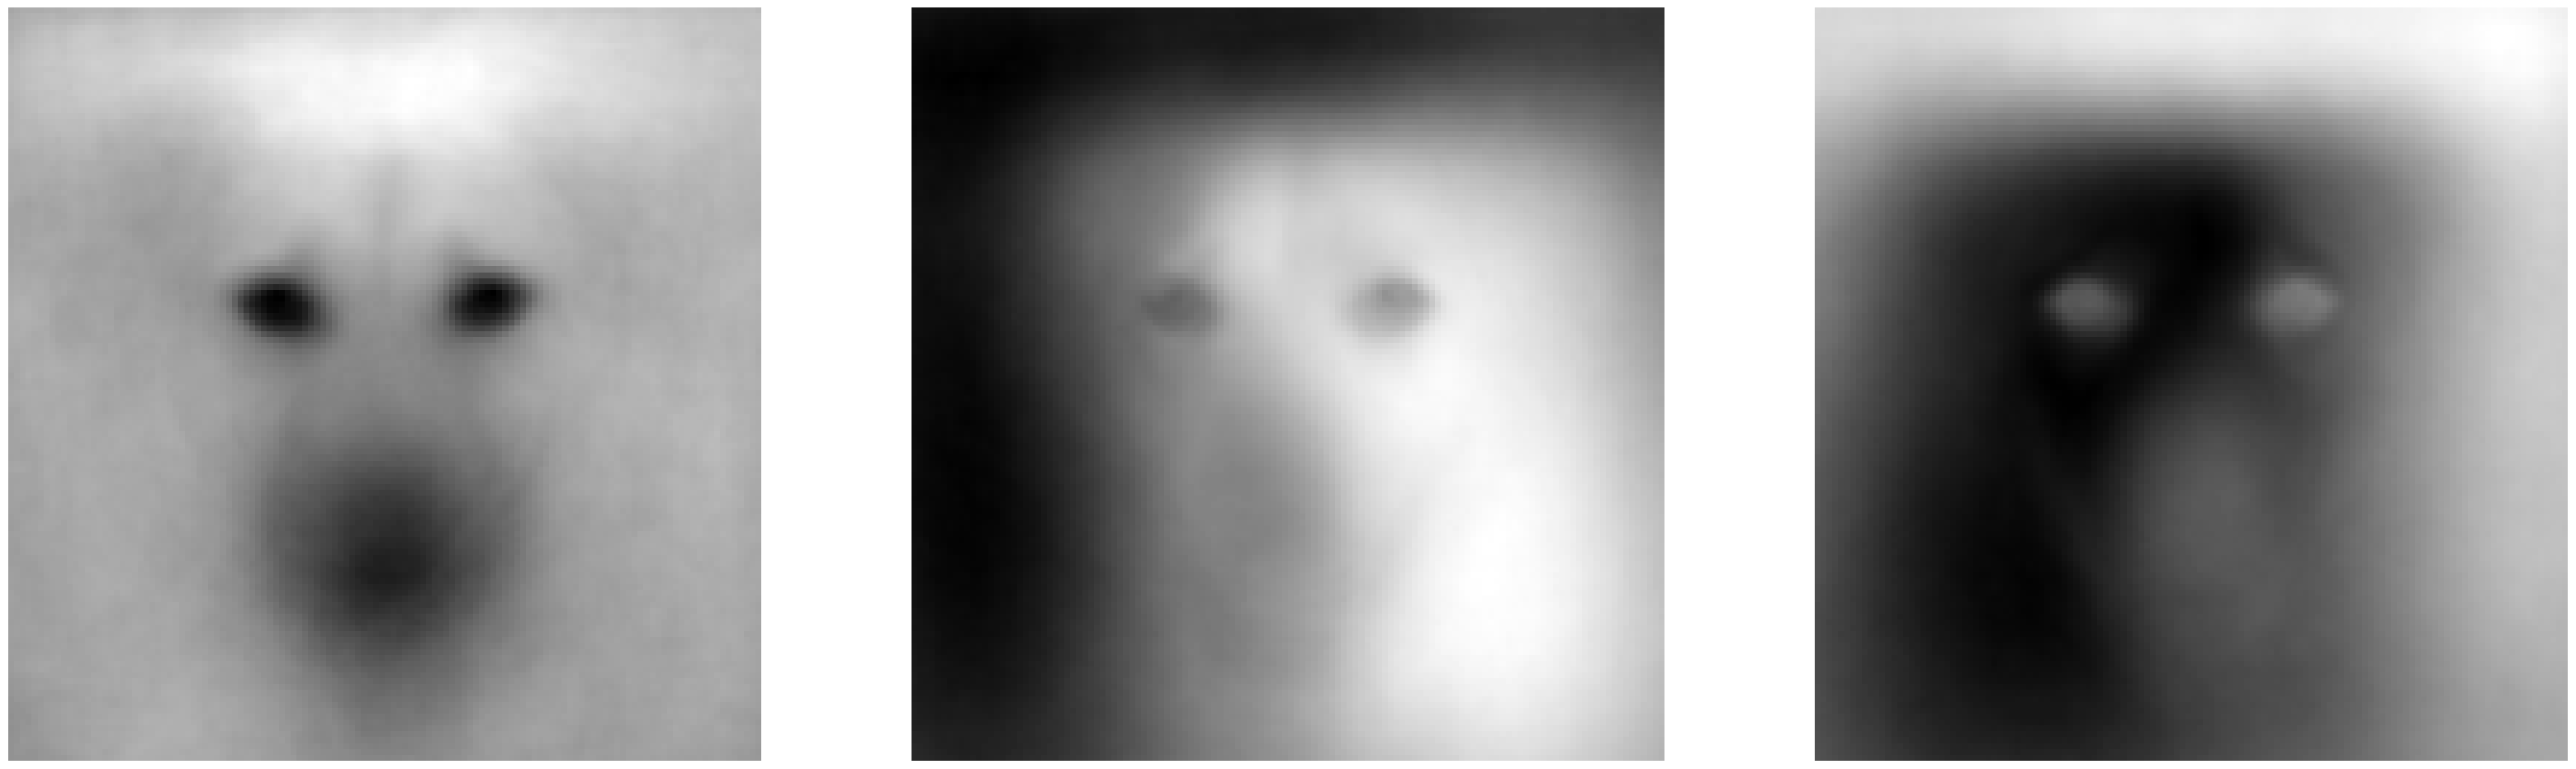

Some pets in eigenpets space: 


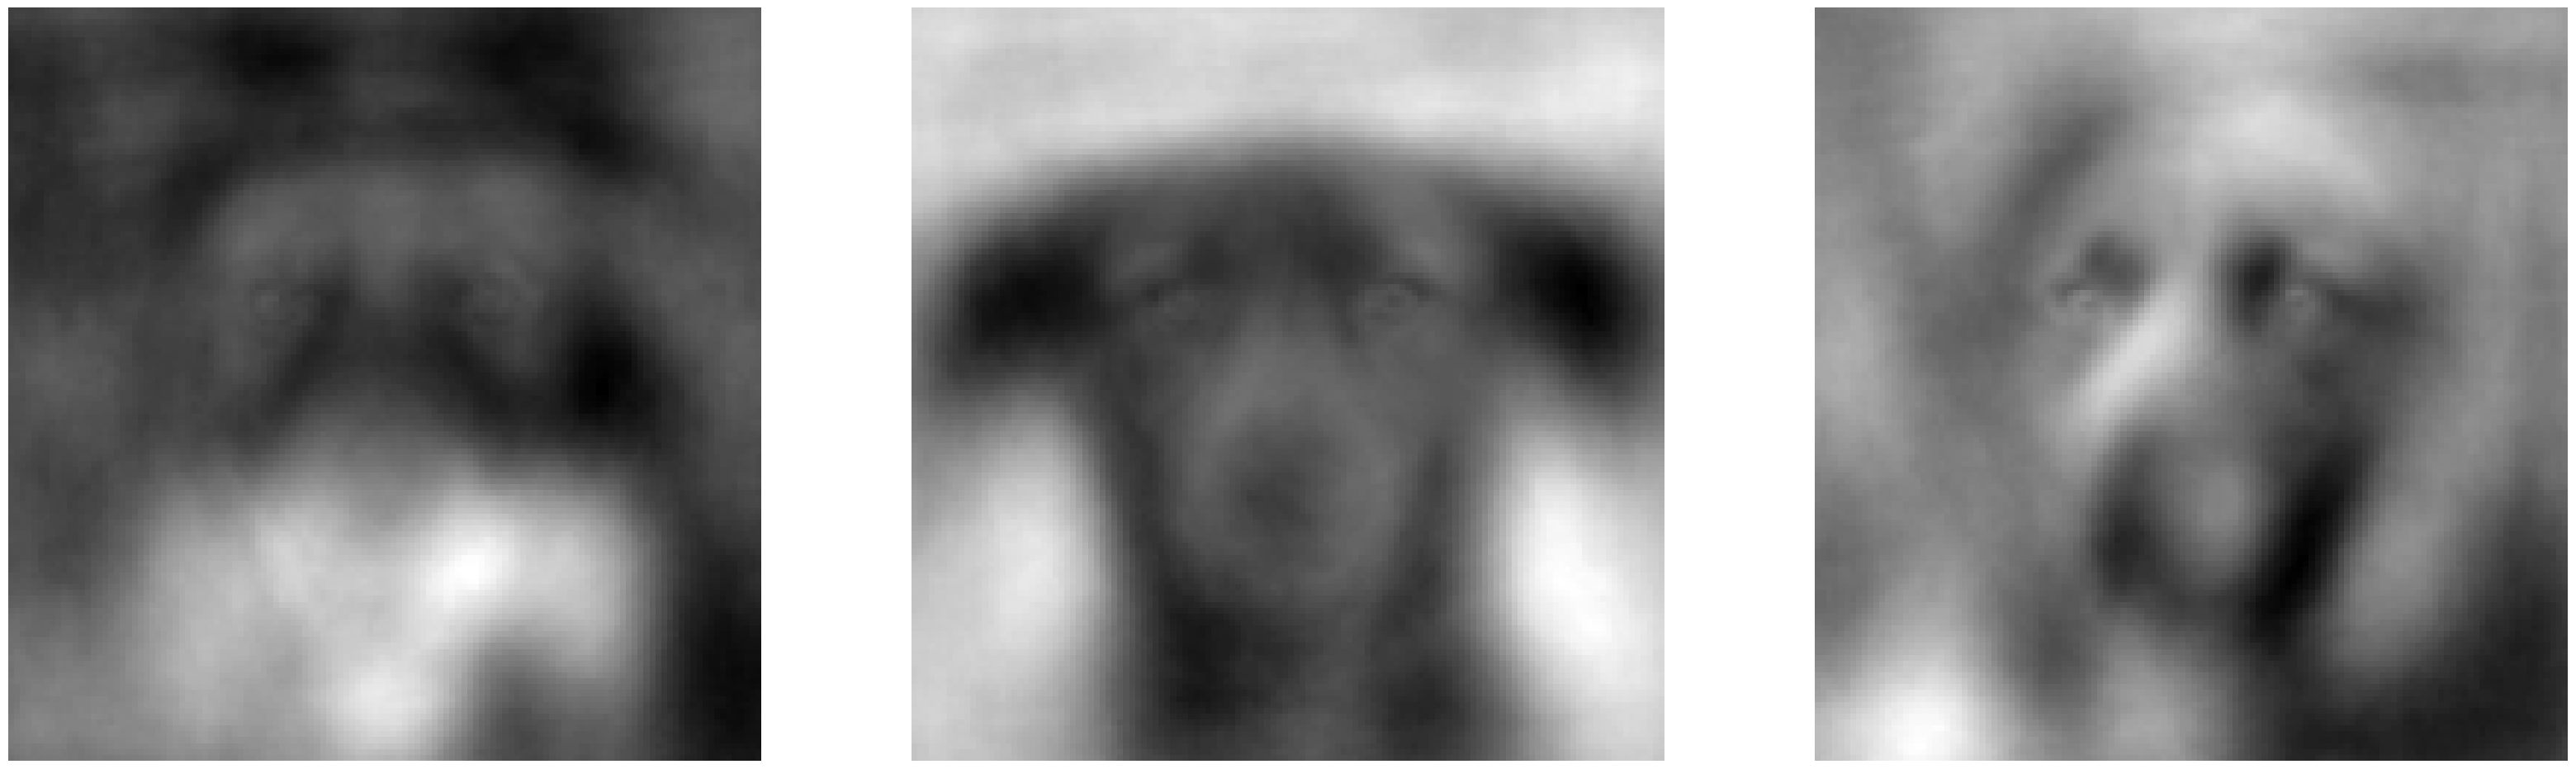

Original pets: 


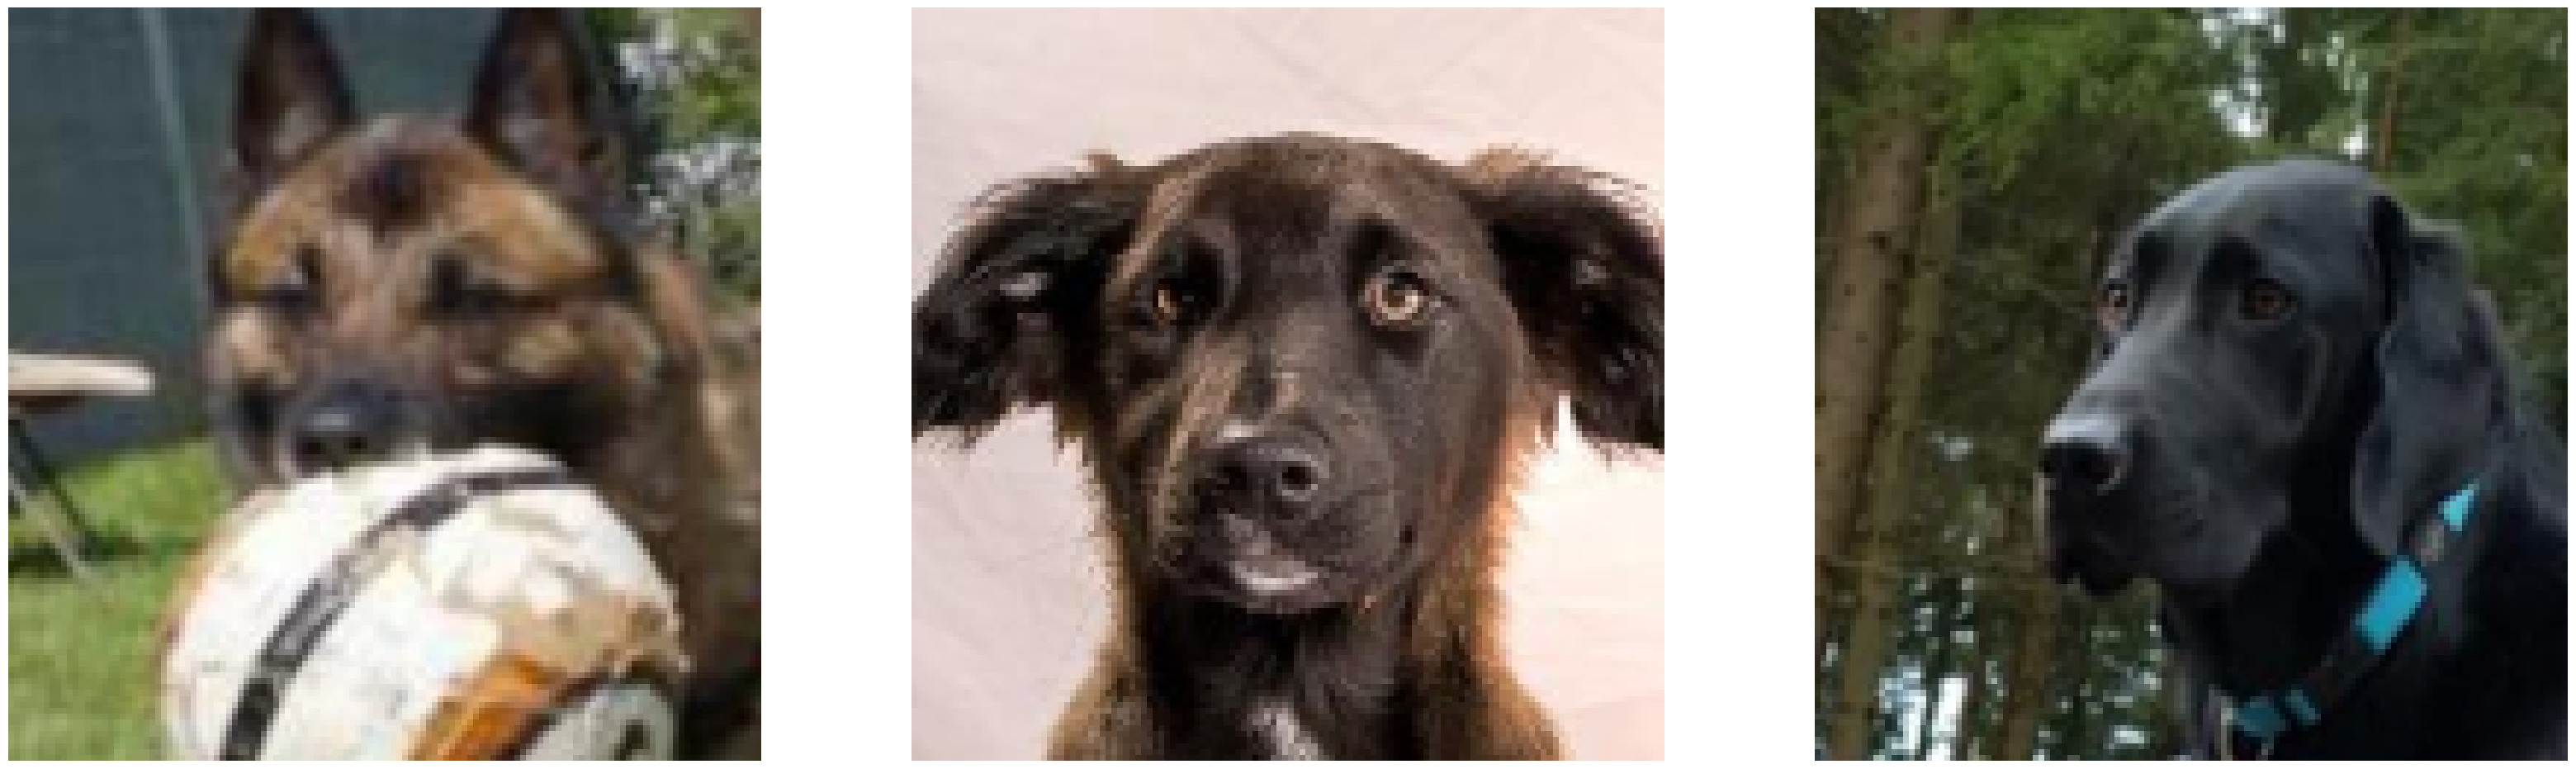

In [21]:
gray = np.array([rgb2gray_img(img) for img in X_train])
gray = MinMaxScaler().fit_transform(gray.reshape(-1, 128*128))
pca = PCA(n_components=0.8,).fit(gray.reshape(gray.shape[0], -1))
# Assume pca is your fitted PCA model and h, w are the original image dimensions
eigenfaces = pca.components_.reshape((-1, 128, 128))
fig = plt.figure(figsize=(40, 40))
print(eigenfaces.shape)
# Visualize the first few eigenfaces

print(f"Some eigenpets: ")
for i, img in enumerate(eigenfaces[0:3]):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

weights = pca.transform(gray.reshape(gray.shape[0], -1))


kinda_original_img = pca.inverse_transform(weights).reshape(-1, 128, 128)
fig = plt.figure(figsize=(40, 40))


print(f"Some pets in eigenpets space: ")
for i, img in enumerate(kinda_original_img[0:3]):

    fig.add_subplot(1, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

fig = plt.figure(figsize=(40, 40))


print(f"Original pets: ")
for i, img in enumerate(X_train[0:3]):

    fig.add_subplot(1, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()



In [22]:
def print_shape(X):
    print(X.shape)
    return X

In [23]:
eigen_pets = make_pipeline(
    DataTransformer(flatten),
    StandardScaler(),
    PCA(n_components=0.5)
)

In [24]:
gray_feat_pipe = make_pipeline(
    DataTransformer(rgb2gray_img),
    ConcatTransformer([
        Desc_transformer([
            hog_descriptor,
            lbp_descriptor,
            lambda d: compute_phog(d, 16)

        ]),
        eigen_pets
    ])
)

In [25]:
color_feat_pipe = Desc_transformer([
    color_histogram,
    # color_layout_descriptor
])

# KNN


In [26]:

main_pipe = make_pipeline(
    
    ConcatTransformer(
        pipes = (
            color_feat_pipe,
            gray_feat_pipe, 
        ),
        keep_original=False,
     ),

    DataTransformer(flatten),
    MinMaxScaler(),

    MLPClassifier(hidden_layer_sizes=(100, 10), max_iter=10000, verbose=True, warm_start=True, learning_rate_init=1e-5),
    

    verbose=True

)

main_pipe.fit(X_train, train_df["label"])
y_pred = main_pipe.predict(X_test)
print(classification_report(test_df["label"], y_pred))




[Pipeline] . (step 1 of 4) Processing concattransformer, total= 7.7min
[Pipeline] ... (step 2 of 4) Processing datatransformer, total=   1.2s
[Pipeline] ...... (step 3 of 4) Processing minmaxscaler, total=   0.9s
Iteration 1, loss = 7.09518628
Iteration 2, loss = 7.09272824
Iteration 3, loss = 7.09046017
Iteration 4, loss = 7.08807632
Iteration 5, loss = 7.08639950
Iteration 6, loss = 7.08426296
Iteration 7, loss = 7.08244979
Iteration 8, loss = 7.07910537
Iteration 9, loss = 7.07787750
Iteration 10, loss = 7.07587116
Iteration 11, loss = 7.07269845
Iteration 12, loss = 7.07093268
Iteration 13, loss = 7.06787113
Iteration 14, loss = 7.06619672
Iteration 15, loss = 7.06344832
Iteration 16, loss = 7.06190892
Iteration 17, loss = 7.06024701
Iteration 18, loss = 7.05637735
Iteration 19, loss = 7.05532671
Iteration 20, loss = 7.05252106
Iteration 21, loss = 7.05046479
Iteration 22, loss = 7.04716820
Iteration 23, loss = 7.04405200
Iteration 24, loss = 7.04079097
Iteration 25, loss = 7.03842

c:\Users\T-Gamer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\T-Gamer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\T-Gamer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.33      1.00      0.50         1
         100       0.00      0.00      0.00         2
        1000       0.00      0.00      0.00         1
        1001       0.00      0.00      0.00         1
        1002       0.00      0.00      0.00         1
        1003       0.00      0.00      0.00         1
        1004       0.00      0.00      0.00         1
        1005       0.00      0.00      0.00         1
        1006       0.00      0.00      0.00         1
        1007       0.00      0.00      0.00         1
        1008       0.00      0.00      0.00         1
        1009       0.00      0.00      0.00         1
         101       0.00      0.00      0.00         2
        1010       0.00      0.00      0.00         1
        1011       0.00      0.00      0.00         1
        1012       1.00      1.00      1.00         1
        1013       0.50    

In [27]:
X_train[0:10].shape

(10, 128, 128, 3)

In [28]:
X_train[0:10].reshape(10, -1).shape

(10, 49152)

In [29]:
print(y_pred == test_df["label"])

1907    False
1356    False
2091    False
3880    False
4565    False
        ...  
1332    False
177     False
7716    False
4333    False
1088    False
Name: label, Length: 1572, dtype: bool


In [30]:
full_pipe = make_pipeline(
    load_pipe,
    
    KNeighborsClassifier(n_neighbors=7),
    verbose = True
)

In [39]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, 
from sklearn.preprocessing import LabelEncoder

# Converting labels to one-hot encoding
# Encode labels into a range from 0 to number of classes - 1
le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_df['label'])
test_labels_encoded = le.transform(test_df['label'])


# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels_encoded)
test_labels = to_categorical(test_labels_encoded)

In [40]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout 

from tensorflow.keras.callbacks import ModelCheckpoint

# For initial training
checkpoint_path_initial = "training/initial/cp-{epoch:04d}.keras"
cp_callback_initial = ModelCheckpoint(
    filepath=checkpoint_path_initial, 
    verbose=1, 
    save_freq='epoch'
    only_weights=True
)

# For fine-tuning
checkpoint_path_fine_tune = "training/fine_tune/cp-{epoch:04d}.keras"
cp_callback_fine_tune = ModelCheckpoint(
    filepath=checkpoint_path_fine_tune, 
    verbose=1, 
    save_freq='epoch',
    only_weights=True
)

from keras.callbacks import EarlyStopping

# Define the early stopping criteria
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    min_delta=0,  # Minimum change in the monitored quantity to qualify as an improvement
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Verbosity mode
    mode='auto',  # Direction of improvement is automatically inferred from the name of the monitored quantity
    restore_best_weights=True,
    
    # Whether to restore model weights from the epoch with the best value of the monitored quantity
)


# Create a new model
model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3),
    pooling='avg',
)
model.trainable = False

# Add a dropout layer
dropout_layer = Dropout(0.5)(model.output)

# Add a new dense layer for your classes
output_layer = tf.keras.layers.Dense(df["label"].nunique(), activation='softmax')(dropout_layer)

# Create a new model
new_model = tf.keras.Model(model.input, output_layer)

new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], )

# Train the model
history_initial = new_model.fit(X_train, train_labels, epochs=5, validation_data=(X_test, test_labels), callbacks=[cp_callback_initial, early_stopping])

# Fine-tune some layers
for layer in model.layers[-20:]:
    layer.trainable = True

# Continue training
new_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history_fine_tune = new_model.fit(X_train, train_labels, epochs=5, validation_data=(X_test, test_labels), callbacks=[cp_callback_fine_tune, early_stopping])

Epoch 1/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.0234 - loss: 10.1502
Epoch 1: saving model to training/initial/cp-0001.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 178s 767ms/step - accuracy: 0.0236 - loss: 10.1448 - val_accuracy: 0.2945 - val_loss: 4.0970
Epoch 2/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.3455 - loss: 3.7340
Epoch 2: saving model to training/initial/cp-0002.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 133s 677ms/step - accuracy: 0.3457 - loss: 3.7327 - val_accuracy: 0.4364 - val_loss: 3.2001
Epoch 3/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.6066 - loss: 1.7020
Epoch 3: saving model to training/initial/cp-0003.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 129s 654ms/step - accuracy: 0.6066 - loss: 1.7018 - val_accuracy: 0.4892 - val_loss: 2.8878
Epoch 4/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.7635 - loss: 0.9062
Epoch 4: saving model to training/initial/cp-0004.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 129s 657ms/step - accuracy: 0.7635

# Transfer learning

## Description
This network has a resnet50 as a base model, with a softmax layer at the end. 

## Training

### Warm up phase
The network was warmed up with only the last layer unfreezed, for 5 epochs.

### Fine tuning phase

The network was fined tuned, with the last 20 layers and the output layer unfreezed. The traning consisted of 69 epochs.

## Results

accuracy: 0.9999 - loss: 0.0047 - val_accuracy: 0.6724 - val_loss: 1.6473

In [46]:
# For initial training
checkpoint_path_initial = "training/initial/cp-{epoch:04d}-{val_loss:.4f}.weights.h5"
cp_callback_initial = ModelCheckpoint(
    filepath=checkpoint_path_initial, 
    verbose=1, 
    save_freq='epoch',
    save_weights_only=True
)

# For fine-tuning
checkpoint_path_fine_tune = "training/fine_tune/cp-{epoch:04d}-{val_loss:.4f}.weights.h5"
cp_callback_fine_tune = ModelCheckpoint(
    filepath=checkpoint_path_fine_tune, 
    verbose=1, 
    save_freq='epoch',
    save_weights_only=True
)

from keras.callbacks import EarlyStopping

# Define the early stopping criteria
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    min_delta=0,  # Minimum change in the monitored quantity to qualify as an improvement
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Verbosity mode
    mode='auto',  # Direction of improvement is automatically inferred from the name of the monitored quantity
    restore_best_weights=True,
    # 
    # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

# load model
model = tf.keras.models.load_model('training/fine_tune/cp-0005.keras')

# Continue training
new_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history_fine_tune = new_model.fit(X_train, train_labels, epochs=64, validation_data=(X_test, test_labels), callbacks=[cp_callback_fine_tune, early_stopping])


Epoch 1/64
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.9558 - loss: 0.2271
Epoch 1: saving model to training/fine_tune/cp-0001-2.0259.weights.h5
197/197 ━━━━━━━━━━━━━━━━━━━━ 173s 830ms/step - accuracy: 0.9558 - loss: 0.2271 - val_accuracy: 0.6081 - val_loss: 2.0259
Epoch 2/64
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.9719 - loss: 0.1940
Epoch 2: saving model to training/fine_tune/cp-0002-1.9830.weights.h5
197/197 ━━━━━━━━━━━━━━━━━━━━ 155s 787ms/step - accuracy: 0.9719 - loss: 0.1940 - val_accuracy: 0.6209 - val_loss: 1.9830
Epoch 3/64
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.9736 - loss: 0.1666
Epoch 3: saving model to training/fine_tune/cp-0003-1.9496.weights.h5
197/197 ━━━━━━━━━━━━━━━━━━━━ 142s 721ms/step - accuracy: 0.9737 - loss: 0.1666 - val_accuracy: 0.6209 - val_loss: 1.9496
Epoch 4/64
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.9803 - loss: 0.1406
Epoch 4: saving model to training/fine_tune/cp-0004-1.9196.weights.h5
197/1

# Generating and storing the embedings

In [47]:
embbeding_net = tf.keras.Model(new_model.input, new_model.layers[-2].output)

# Save the embeddings
train_embeddings = embbeding_net.predict(X_train)
test_embeddings = embbeding_net.predict(X_test)



197/197 ━━━━━━━━━━━━━━━━━━━━ 117s 553ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 542ms/step


FileNotFoundError: [Errno 2] No such file or directory: 'embeddings/tindog-resnet50-softmax-5warm-69fine\\train_embeddings.npy'

In [48]:
embeddings_dir = "embeddings/tindog-resnet50-softmax-5warm-69fine"

# create if not exists
os.makedirs(embeddings_dir, exist_ok=True)

# Save the embeddings
np.save(os.path.join(embeddings_dir, 'train_embeddings.npy'), train_embeddings)
np.save(os.path.join(embeddings_dir, 'test_embeddings.npy'), test_embeddings)

# saving the labels
np.save(os.path.join(embeddings_dir, 'train_labels.npy'), train_labels)
np.save(os.path.join(embeddings_dir, 'test_labels.npy'), test_labels)

# Using the embeddings for KNN

In [72]:
embeddings_dir = "embeddings/tindog-resnet50-softmax-5warm-69fine"

# Load the embeddings
train_embeddings = np.load(os.path.join(embeddings_dir, 'train_embeddings.npy'))
test_embeddings = np.load(os.path.join(embeddings_dir, 'test_embeddings.npy'))

# Load the labels
train_labels = np.load(os.path.join(embeddings_dir, 'train_labels.npy'))
test_labels = np.load(os.path.join(embeddings_dir, 'test_labels.npy'))

train_labels= np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

# Create a new model

model = KNeighborsClassifier(n_neighbors=3, metric='cosine')
model.fit(train_embeddings, train_labels)
print(classification_report(test_labels, model.predict(test_embeddings)))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1.00         1
           2       0.67      1.00      0.80         2
           3       0.50      1.00      0.67         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       0.50      1.00      0.67         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       0.50      0.50      0.50         2
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
          16       0.33      1.00      0.50         1
          17       0.50    

c:\Users\T-Gamer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\T-Gamer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\T-Gamer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

# Siamese network with triplet loss for extracting features

In [31]:
%pip install joblib
#call
from joblib import dump

# Save the model
dump(main_pipe, 'model.joblib')


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


PicklingError: Can't pickle <function <lambda> at 0x000002255FAF3100>: it's not found as __main__.<lambda>